In [354]:
import numpy as np
import GPy
import matplotlib.pyplot as plt
import scipy

In [427]:
def pf(x, model, mean=None, cov=None, l=0):
    # model = gp.output[0].model
    kern = model.kern
    X = model.X
    #x = np.array(x).reshape(-1, 1)
    
    #if (mean is None) and (cov is None):
    mean, cov = model.predict(x, full_cov=True)
    
#     print("mean",mean)
    var = np.diag(cov).reshape(-1, 1)
    std = np.sqrt(var).reshape(-1, 1)
    aux_std = np.reciprocal(std)
    aux_var = np.reciprocal(var)
    mean = mean.reshape(-1, 1)
#     print("mean", mean.shape,"var", var.shape)
    norm = scipy.stats.norm(mean, np.sqrt(var))
    fz = norm.pdf(l)
    Fz = norm.cdf(l)
    grad_mean , grad_var = model.predictive_gradients(x)
    grad_std = (1/2.0)*grad_var

    # cov = kern.K(X, X) + np.eye(X.shape[0]) * 1e-3
    # L = scipy.linalg.cholesky(cov, lower=True)
    # u = scipy.linalg.solve(L, np.eye(X.shape[0]))
    # Ainv = scipy.linalg.solve(L.T, u)

    dims = range(x.shape[1])
    grad_Fz = []

    for d in dims:
        # K1 = np.diag(np.dot(np.dot(kern.dK_dX(x, X, d), Ainv), kern.dK_dX2(X, x, d)))
        # K2 = np.diag(kern.dK2_dXdX2(x, x, d, d))
        # var_grad = K2 - K1
        # var_grad = var_grad.reshape(-1, 1)
        grd_mean_d = grad_mean[:, d].reshape(-1, 1)
        grd_std_d = grad_std[:, d].reshape(-1, 1)
        print("grd_mean ",grd_mean_d, "var_grad ",grd_std_d )
        print("std",std)
        print("aux_var", aux_var)
        print("fz",fz)
        grad_Fz.append(fz * aux_var * (mean * grd_std_d - grd_mean_d * std))
    grad_Fz = np.stack(grad_Fz, axis=1)
#     print("grad_mean", grad_mean.shape, "grad_var", grad_Fz.shape)
    
#     print("grad_Fz",grad_Fz)
    return Fz.reshape(-1,1), grad_Fz[:,:,0]

In [407]:
class GP_test():
    """
A toy function GP

ARGS
 min: scalar defining min range of inputs
 max: scalar defining max range of inputs
 seed: int, RNG seed
 x_dim: designs dimension
 a_dim: input dimensions
 xa: n*d matrix, points in space to eval testfun
 NoiseSD: additive gaussaint noise SD

RETURNS
 output: vector of length nrow(xa)
 """

    def __init__(self, xamin, xamax, seed=11, x_dim=1):
        self.seed = seed
        self.dx = x_dim
        self.da = 0
        self.dxa = x_dim
        self.xmin = np.array([xamin for i in range(self.dxa)])
        self.xmax = np.array([xamax for i in range(self.dxa)])
        vr = 4.
        ls = 10
        self.HP =  [vr,ls]
        self.KERNEL = GPy.kern.RBF(input_dim=self.dxa, variance=vr, lengthscale=([ls] * self.dxa), ARD=True)
        self.generate_function()

    def __call__(self, xa, noise_std=1e-2):
        assert len(xa.shape) == 2, "xa must be an N*d matrix, each row a d point"
        assert xa.shape[1] == self.dxa, "Test_func: wrong dimension inputed"

        xa = self.check_input(xa)

        ks = self.KERNEL.K(xa, self.XF)
        out = np.dot(ks, self.invCZ)

        E = np.random.normal(0, noise_std, xa.shape[0])

        return (out.reshape(-1, 1) + E.reshape(-1, 1))

    def generate_function(self):
        print("Generating test function")
        np.random.seed(self.seed)

        self.XF = np.random.uniform(size=(50, self.dxa)) * (self.xmax - self.xmin) + self.xmin


        mu = np.zeros(self.XF.shape[0])

        C = self.KERNEL.K(self.XF, self.XF)

        Z = np.random.multivariate_normal(mu, C).reshape(-1, 1)
        invC = np.linalg.inv(C + np.eye(C.shape[0]) * 1e-3)

        self.invCZ = np.dot(invC, Z)

    def check_input(self, x):
        if not x.shape[1] == self.dxa or (x > self.xmax).any() or (x < self.xmin).any():
            raise ValueError("x is wrong dim or out of bounds")
        return x

test_f = GP_test([0],[100], seed=12)

Generating test function


Optimization restart 1/5, f = -224.34993086050994
Optimization restart 2/5, f = -224.3499308602714
Optimization restart 3/5, f = -224.34993085997263
Optimization restart 4/5, f = -224.34993085997957
Optimization restart 5/5, f = -224.34993086070233


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f37602b8080>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7f3760809f98>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7f37602b8828>]}

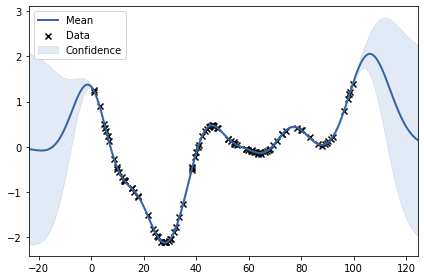

In [422]:
# def Function(x):
    
#     f = np.sum(x**2.0 -0.1,axis=1)
#     f = f + np.random.normal(0,0.001,len(x))
#     return f.reshape(-1,1)

X = np.random.random((100,1))*100
Y = test_f(X)

Q = GPy.kern.RBF(input_dim=1, ARD=True)
model = GPy.models.GPRegression(X, Y, Q)
model.optimize_restarts(5);
model.plot()

grd_mean  [[0.18292442]
 [0.18226587]
 [0.18160406]
 [0.18093901]
 [0.18027074]
 [0.17959929]
 [0.17892466]
 [0.17824689]
 [0.17756599]
 [0.17688199]
 [0.17619491]
 [0.17550477]
 [0.1748116 ]
 [0.17411542]
 [0.17341626]
 [0.17271413]
 [0.17200906]
 [0.17130107]
 [0.1705902 ]
 [0.16987646]] var_grad  [[2.10791038e-07]
 [2.28490588e-07]
 [2.45773387e-07]
 [2.62635433e-07]
 [2.79071282e-07]
 [2.95077207e-07]
 [3.10648377e-07]
 [3.25782098e-07]
 [3.40473934e-07]
 [3.54720419e-07]
 [3.68518785e-07]
 [3.81865469e-07]
 [3.94757412e-07]
 [4.07192580e-07]
 [4.19167922e-07]
 [4.30681813e-07]
 [4.41730650e-07]
 [4.52313225e-07]
 [4.62429693e-07]
 [4.72076777e-07]]
std [[0.01273186]
 [0.01273226]
 [0.0127327 ]
 [0.01273317]
 [0.01273367]
 [0.0127342 ]
 [0.01273476]
 [0.01273535]
 [0.01273597]
 [0.01273661]
 [0.01273728]
 [0.01273797]
 [0.01273869]
 [0.01273943]
 [0.01274019]
 [0.01274098]
 [0.01274178]
 [0.01274261]
 [0.01274346]
 [0.01274432]]
aux_var [[6169.02398422]
 [6168.63043408]
 [6168.2056

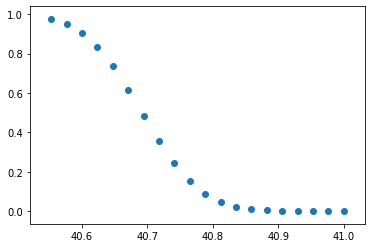

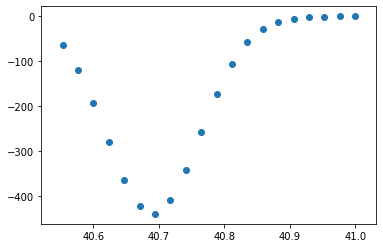

In [428]:
x = np.linspace(40.55276382,41,20)[:,None]
PF, grad_PF = pf(x,model,0)
modulus = np.sum(grad_PF**2,axis=1)
plt.scatter(x,PF)
plt.show()
plt.scatter(x,grad_PF)
plt.show()

In [376]:
model.predict(X, full_cov=True)

(array([[0.22764841],
        [0.29373952],
        [0.51214921],
        [0.91188407],
        [0.62455157],
        [0.56653179],
        [0.52331047],
        [0.30709496],
        [0.39714267],
        [0.9082383 ]]),
 array([[ 1.25389101e-06,  7.38705275e-08, -1.98381542e-08,
          1.76168413e-10, -2.23190000e-08, -4.37773586e-08,
          4.26079545e-08,  4.03957223e-08, -2.23185594e-08,
          1.81545730e-08],
        [ 7.38705275e-08,  1.23857867e-06,  2.16139213e-08,
          2.27263186e-09,  2.53298396e-08,  4.46124169e-08,
         -4.57859812e-08, -4.20102815e-08,  2.39122997e-08,
         -2.15487717e-08],
        [-1.98381542e-08,  2.16139213e-08,  1.26426280e-06,
         -7.56787699e-09, -1.96681711e-08, -6.26475192e-08,
          1.03876502e-07, -2.87376523e-09,  2.20213607e-08,
          2.16623270e-08],
        [ 1.76168413e-10,  2.27263186e-09, -7.56787699e-09,
          1.31052775e-06, -7.00623559e-09,  3.94598487e-09,
          1.16868399e-08, -1.64134839

In [344]:
a = np.array([1,2,3]).reshape(1,-1)
np.matmul(np.transpose(a),a)

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])

In [345]:
a

array([[1, 2, 3]])

In [308]:
model

GP_regression.,value,constraints,priors
rbf.variance,66.16341900218809,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,1.3506807172488282e-07,+ve,


In [250]:
model.likelihood[:]

array([1.35068072e-07])

 /home/juan/.local/lib/python3.6/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


{'dataplot': [<matplotlib.collections.PathCollection at 0x7f3761186278>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x7f376121ea58>]}

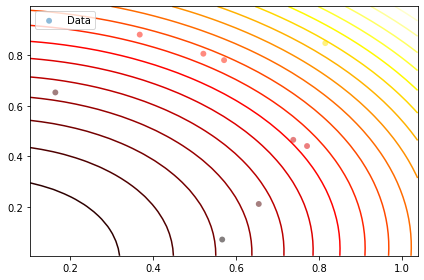

In [238]:
model.plot()

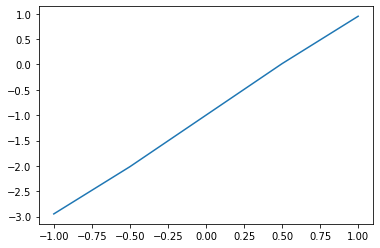

In [28]:
plt.plot(X,model.predictive_gradients(X)[0].reshape(-1))

In [62]:
model.predictive_gradients(X)[0][:,0]

array([[-2.94774307],
       [-2.01629815],
       [-1.00005323],
       [ 0.01630414],
       [ 0.95138109]])

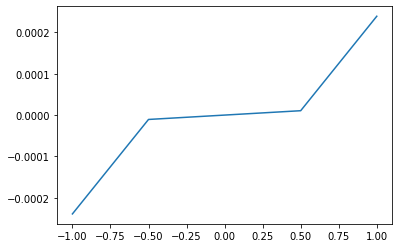

In [27]:
plt.plot(X,model.predictive_gradients(X)[1].reshape(-1))

In [265]:
model.kern

rbf.,value,constraints,priors
variance,66.16341900218809,+ve,
lengthscale,"(2,)",+ve,


{'dataplot': [<matplotlib.collections.PathCollection at 0x7fa3085ea748>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fa3085ea6a0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fa3085eaeb8>]}

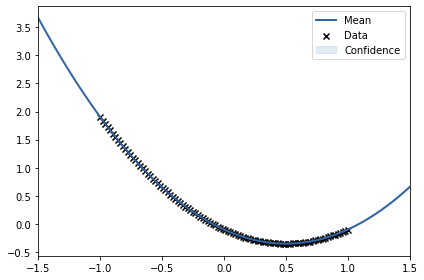

In [159]:
model.plot()

In [179]:
x_plot = np.linspace(-1.0,1.0,100).reshape(-1,1)

In [180]:
cov = kern.K(X,X) + np.eye(X.shape[0])*1e-3
L = scipy.linalg.cholesky(cov, lower=True)
u = scipy.linalg.solve(L, np.eye(X.shape[0]))
Ainv = scipy.linalg.solve(L.T, u)
Ainv;

In [281]:
Xdims = np.array([[0,1],[1,2]])

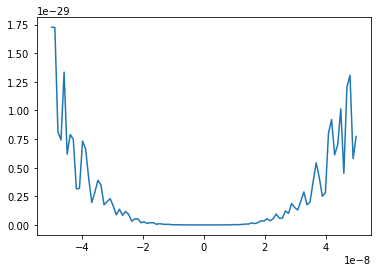

In [348]:
x= np.linspace(-0.00000005,0.00000005,100)
fx = 2*x**4 + x**4 *np.sin(1.0/x)
plt.plot(x,fx)

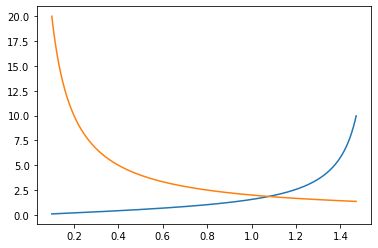

In [306]:
x = np.linspace(0.1,np.pi/2.0-0.1,1000)
f1 = np.tan(x)
f2 = 2.0/x
plt.plot(x,f1)
plt.plot(x,f2)

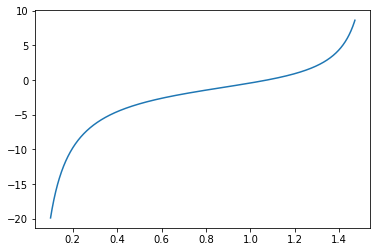

In [307]:
plt.plot(x,f1-f2)